In [1]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf

from typing import List, Optional

In [2]:
mt5.initialize()

True

In [3]:
def get_highest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)

    merged_df = pd.concat([left_bars, right_bars])
    highest_bar = merged_df.nlargest(1, 'high')
    highest_bar = highest_bar.iloc[-1]

    return pivot_bar if highest_bar['high'] < pivot_bar['high'] else highest_bar

def get_lowest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)
    
    merged_df = pd.concat([left_bars, right_bars])
    lowest_bar = merged_df.nsmallest(1, 'low')
    lowest_bar = lowest_bar.iloc[-1]

    return pivot_bar if lowest_bar['low'] > pivot_bar['low'] else lowest_bar

def is_bearish_divergence(df: pd.DataFrame, current_candle: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_high = df[(df['rsi_pivot_high']) & (df['time'] < current_candle['time']) & (df['rsi'] > current_candle['rsi'])]
        
    if not nearest_rsi_pivot_high.empty:
        nearest_rsi_pivot_high = nearest_rsi_pivot_high.iloc[-1]
        
        if nearest_rsi_pivot_high['rsi'] > 70:
            current_candle = get_highest_pivot_bar(df, current_candle)
            nearest_pivot_high_candle = get_highest_pivot_bar(df, nearest_rsi_pivot_high)
            
            if current_candle['high'] > nearest_pivot_high_candle['high']:
                return nearest_rsi_pivot_high
    
    return None

def is_bullish_divergence(df: pd.DataFrame, current_candle: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_low = df[(df['rsi_pivot_low']) & (df['time'] < current_candle['time']) & (df['rsi'] < current_candle['rsi'])]
    if not nearest_rsi_pivot_low.empty:
        nearest_rsi_pivot_low = nearest_rsi_pivot_low.iloc[-1]

        if nearest_rsi_pivot_low['rsi'] < 40:
            current_candle = get_lowest_pivot_bar(df, current_candle)
            nearest_pivot_low_candle = get_lowest_pivot_bar(df, nearest_rsi_pivot_low)

            if current_candle['low'] < nearest_pivot_low_candle['low']:
                return nearest_rsi_pivot_low
            
    return None
    
def detect_divergence(df: pd.DataFrame):
    price_lines = []
    rsi_lines = []

    for _, current_candle in df.iterrows():
        if current_candle['rsi_pivot_low']:
            bullish_divergence_point = is_bullish_divergence(df, current_candle)
            if bullish_divergence_point is not None:
                rsi_lines.append([
                    (bullish_divergence_point['time'], bullish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])
                
                current_candle = get_lowest_pivot_bar(df, current_candle)
                nearest_pivot_low_candle = get_lowest_pivot_bar(df, bullish_divergence_point)
                price_lines.append([
                    (nearest_pivot_low_candle['time'], nearest_pivot_low_candle['low']),
                    (current_candle['time'], current_candle['low'])
                ])

        if current_candle['rsi_pivot_high']:
            bearish_divergence_point = is_bearish_divergence(df, current_candle)
            if bearish_divergence_point is not None:
                rsi_lines.append([
                    (bearish_divergence_point['time'], bearish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])

                current_candle = get_highest_pivot_bar(df, current_candle)
                nearest_pivot_high_candle = get_highest_pivot_bar(df, bearish_divergence_point)
                price_lines.append([
                    (nearest_pivot_high_candle['time'], nearest_pivot_high_candle['high']),
                    (current_candle['time'], current_candle['high'])
                ])

    return price_lines, rsi_lines

In [4]:
rates = mt5.copy_rates_from_pos('BTCUSD', mt5.TIMEFRAME_M5, 0, 200)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(rates['time'], unit='s')
df['rsi'] = ta.rsi(df['close'], 14)
df['atr'] = ta.atr(df['high'], df['low'], df['close'], 14)

df.dropna(inplace=True)
df.set_index(df['time'], inplace=True)

window_size = 3
df['rsi_pivot_high'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).max()
df['rsi_pivot_low'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).min()

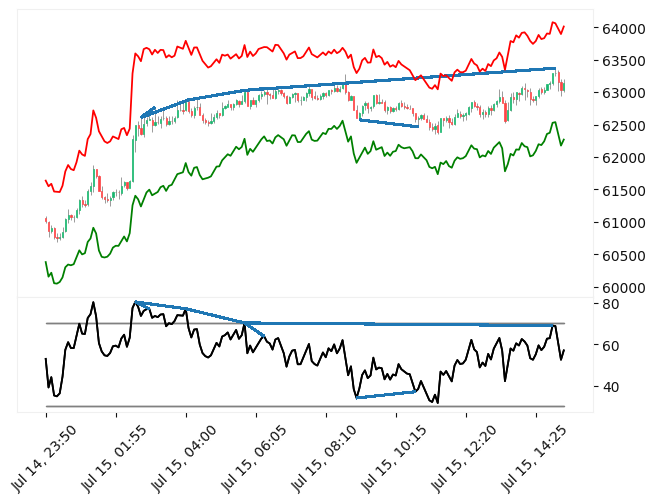

In [5]:
df = df.tail(200)
price_lines, rsi_lines = detect_divergence(df)

plots = [
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=30, y2=30, color="gray")),
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=70, y2=70, color="gray")),
    mpf.make_addplot(df['close'] + df['atr'] * 5, panel=0, color='r'),
    mpf.make_addplot(df['close'] - df['atr'] * 5, panel=0, color='g'),
]
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'grid.alpha':0}, figcolor='#fff', facecolor="#fff")
_, axs = mpf.plot(
    df,
    type='candle',
    style=style,
    volume=False,
    ylabel='',
    ylabel_lower='',
    addplot=plots,
    returnfig=True,
    alines=dict(alines=price_lines))

rsi_lines = mpf._utils._construct_aline_collections(dict(alines=rsi_lines), df.index)
axs[2].add_collection(rsi_lines);

In [6]:
symbol = 'BTCUSD'
risk_amount = 30
order_type = mt5.ORDER_TYPE_SELL
info_tick = mt5.symbol_info_tick(symbol)
atr = df['atr'].iloc[-2]

entry = 0
stop_loss = 0

match order_type:
    case mt5.ORDER_TYPE_BUY:
        entry = info_tick.ask
        stop_loss = entry - atr * 5
    case mt5.ORDER_TYPE_SELL:
        entry = info_tick.bid
        stop_loss = entry + atr * 5

trade_volume = risk_amount / abs(entry - stop_loss)
trade_volume = round(trade_volume, 2)

request = {
    'action': mt5.TRADE_ACTION_DEAL,
    'symbol': symbol,
    'deviation': 10,
    'type': order_type,
    'volume': trade_volume,
    'price': entry,
    'sl': stop_loss
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10009, deal=156132144, order=208039118, volume=0.03, price=63136.05, bid=63136.05, ask=63136.47, comment='', request_id=4110830214, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='BTCUSD', volume=0.03, price=63136.05, stoplimit=0.0, sl=63995.66804876473, tp=0.0, deviation=10, type=1, type_filling=0, type_time=0, expiration=0, comment='', position=0, position_by=0))

In [7]:
positions = mt5.positions_get(symbol=symbol)
positions

(TradePosition(ticket=208039118, time=1721056744, time_msc=1721056744767, time_update=1721056744, time_update_msc=1721056744767, type=1, magic=0, identifier=208039118, reason=3, volume=0.03, price_open=63136.05, sl=63995.67, tp=0.0, price_current=63136.47, swap=0.0, profit=-0.01, symbol='BTCUSD', comment='', external_id=''),)

In [8]:
request = {
    'action': mt5.TRADE_ACTION_SLTP,
    'position': positions[0].ticket,
    'sl': 63571.40
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10009, deal=0, order=0, volume=0.03, price=63146.48, bid=63149.93, ask=63149.93, comment='', request_id=4110830215, retcode_external=0, request=TradeRequest(action=6, magic=0, order=0, symbol='', volume=0.0, price=0.0, stoplimit=0.0, sl=63571.4, tp=0.0, deviation=0, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=208039118, position_by=0))